# Binning studies

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import defaultdict

mpl.rcParams['figure.figsize'] = (6,6)
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams["image.origin"] = 'lower'

In [2]:
config = {
    "base_dir":        "/storage/vbsjjlnu/VBSjjlnu_v7/",
    "plot_config":     "FullRun2_v7",
    "cut":             "boost_sig",
    "model_version":   "v",
}

In [3]:
import os

config_base_dir = os.path.join(config["base_dir"], config["plot_config"])

# create the model directory
model_dir   = os.path.join(config_base_dir, config["cut"] , "models",  config["model_version"])
os.makedirs(model_dir, exist_ok=True)

import yaml
model_config_file = open(model_dir + "/model_config.yml", "r")
model_config = yaml.safe_load(model_config_file)

for key in ["samples_version", "cols"]:
    config[key] = model_config[key]

In [4]:
# load numpy
samples_dir = os.path.join(config_base_dir, config["cut"] , "samples", config["samples_version"])
import pickle
signal = pickle.load(open(os.path.join(samples_dir, "for_training/signal_balanced.pkl"),     "rb"))
bkg    = pickle.load(open(os.path.join(samples_dir, "for_training/background_balanced.pkl"), "rb"))

In [5]:
X_sig = signal[config["cols"]].values
X_bkg = bkg[config["cols"]].values
Y_sig = np.ones(len(X_sig))
Y_bkg = np.zeros(len(X_bkg))
W_sig = (signal["weight_norm"]).values
W_bkg = (bkg["weight_norm"]).values
Wnn_sig = (signal["weight"]).values
Wnn_bkg = (bkg["weight"]).values

X = np.vstack([X_sig, X_bkg])
Y = np.hstack([Y_sig, Y_bkg])
W = np.hstack([W_sig, W_bkg])
Wnn = np.hstack([Wnn_sig, Wnn_bkg])

scaler = pickle.load(open(f"{model_dir}/scaler_model.pkl", "rb"))
X_scaled = scaler.fit_transform(X)

In [6]:
import tensorflow as tf

model = tf.keras.models.load_model(os.path.join(model_dir, "model.h5"))

model.summary()


Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_115 (Dense)            (None, 64)                1792      
_________________________________________________________________
batch_normalization_64 (Batc (None, 64)                256       
_________________________________________________________________
activation_13 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_116 (Dense)            (None, 64)                4160      
_________________________________________________________________
batch_normalization_65 (Batc (None, 64)                256       
_________________________________________________________________
activation_14 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_117 (Dense)            (None, 64)              

In [7]:
bkg["y"] = model.predict(scaler.transform(bkg[config["cols"]].values), batch_size=2048)
signal["y"] = model.predict(scaler.transform(signal[config["cols"]].values), batch_size=2048)

In [17]:
bkg.sample_name.unique()

array(['top', 'DY', 'Wjets_HT', 'VV', 'VBF-V', 'VVV', 'Vg', 'VgS', 'Fake'],
      dtype=object)

In [13]:
wjets = bkg[bkg["sample_name"] == "Wjets_HT"]
top = bkg[bkg["sample_name"] == "top"]
dy = bkg[bkg["sample_name"] == "DY"]

Without weights

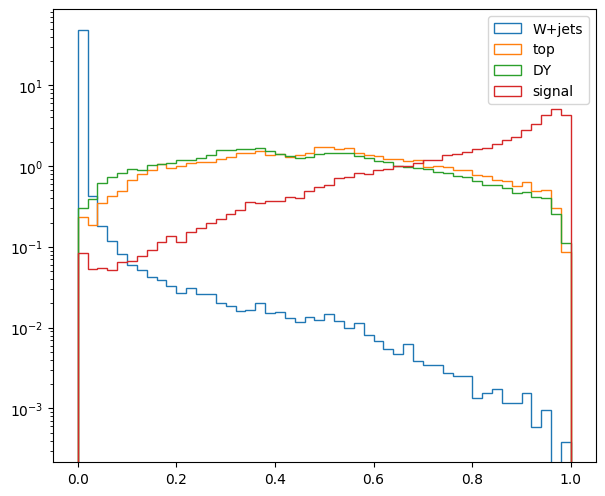

In [22]:
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
plt.hist(bkg[bkg["sample_name"] == "Wjets_HT"]["y"], bins=50,range=(0,1), density=True, label="W+jets", histtype="step" )
plt.hist(bkg[bkg["sample_name"] == "top"]["y"],   bins=50,range=(0,1), density=True, label="top",    histtype="step")
plt.hist(bkg[bkg["sample_name"] == "DY"]["y"],    bins=50,range=(0,1), density=True, label="DY",     histtype="step")

plt.hist(signal["y"], bins=50,density=True, label="signal", histtype="step")
plt.yscale("log")
plt.legend()

With weights

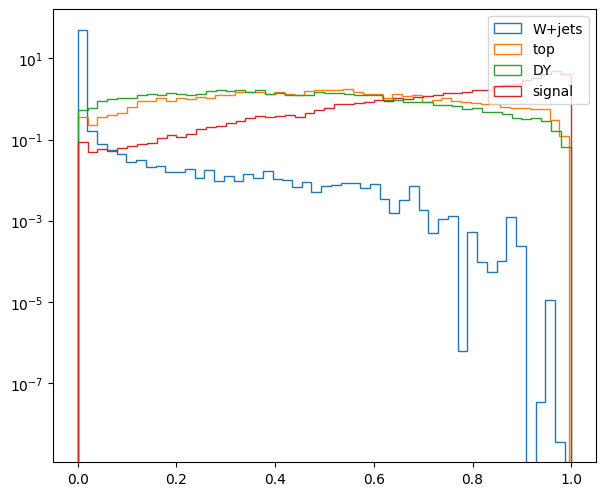

In [29]:
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
plt.hist(wjets["y"], weights=wjets.weight_norm, bins=50, density=True, label="W+jets", histtype="step")
plt.hist(top["y"],   weights=top.weight_norm,  bins=50, density=True, label="top",    histtype="step")
plt.hist(dy["y"],    weights=dy.weight_norm,  bins=50, density=True, label="DY",     histtype="step")

plt.hist(signal["y"], weights=signal.weight_norm, bins=50,density=True, label="signal", histtype="step")
plt.yscale("log")
plt.legend()

## Cumulative distribution for signal

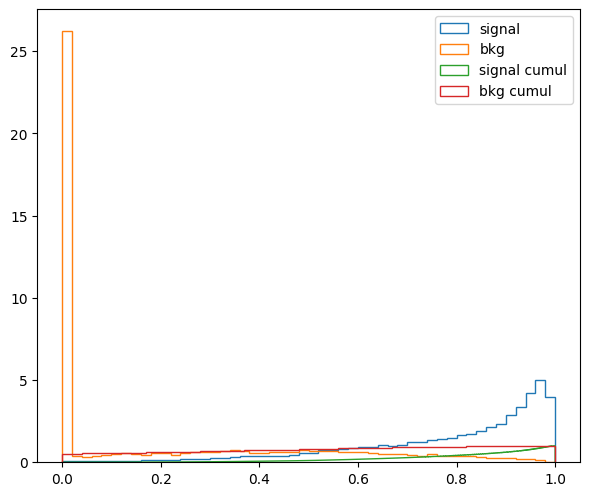

In [31]:
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)

plt.hist(signal["y"], weights=signal.weight, bins=50,density=True, label="signal", histtype="step",range=(0,1))
plt.hist(bkg["y"], weights=bkg.weight, bins=50,density=True, label="bkg", histtype="step",range=(0,1))
hcumul = plt.hist(signal["y"], weights=signal.weight, bins=1000,cumulative=True, density=True, range=(0,1),label="signal cumul", histtype="step")
hcumul_bkg = plt.hist(bkg["y"], weights=bkg.weight, bins=100,cumulative=True, density=True, range=(0,1),label="bkg cumul", histtype="step")
plt.legend()

In [32]:
hcumul

(array([3.18615208e-04, 5.99026264e-04, 7.27979919e-04, 7.75514305e-04,
        8.51087394e-04, 1.00259926e-03, 1.07923476e-03, 1.26383687e-03,
        1.28346434e-03, 1.37957374e-03, 1.38581263e-03, 1.41036636e-03,
        1.47712840e-03, 1.53041008e-03, 1.53916217e-03, 1.60469182e-03,
        1.69782736e-03, 1.69782736e-03, 1.72411599e-03, 1.75863318e-03,
        1.80339220e-03, 1.86526983e-03, 1.89685385e-03, 1.95248021e-03,
        1.95248021e-03, 2.04768045e-03, 2.13784172e-03, 2.21085612e-03,
        2.36078300e-03, 2.37556069e-03, 2.38868616e-03, 2.42151003e-03,
        2.47752810e-03, 2.48690567e-03, 2.50588535e-03, 2.54648345e-03,
        2.55563825e-03, 2.67070516e-03, 2.70274033e-03, 2.72629783e-03,
        2.79722013e-03, 2.83265602e-03, 2.87969987e-03, 2.89682448e-03,
        2.97580601e-03, 3.01330623e-03, 3.07866355e-03, 3.10852192e-03,
        3.18328892e-03, 3.20852774e-03, 3.27760145e-03, 3.30998143e-03,
        3.37923947e-03, 3.49344286e-03, 3.53493865e-03, 3.569290

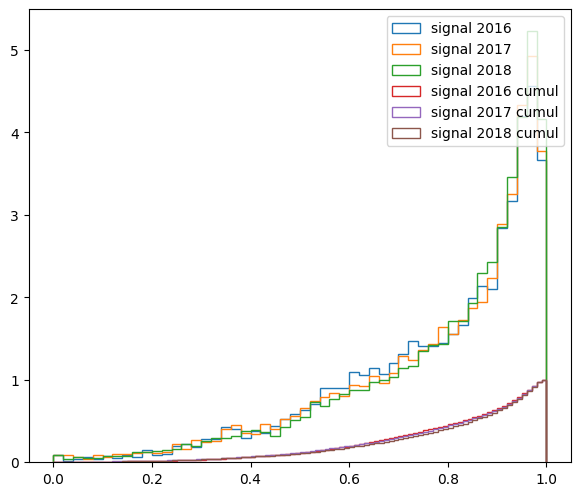

In [35]:
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)

plt.hist(signal[signal.year==2016]["y"], weights=signal[signal.year==2016].weight, bins=50,density=True, label="signal 2016", histtype="step",range=(0,1))
plt.hist(signal[signal.year==2017]["y"], weights=signal[signal.year==2017].weight, bins=50,density=True, label="signal 2017", histtype="step",range=(0,1))
plt.hist(signal[signal.year==2018]["y"], weights=signal[signal.year==2018].weight, bins=50,density=True, label="signal 2018", histtype="step",range=(0,1))

hcumul = plt.hist(signal[signal.year==2016]["y"], weights=signal[signal.year==2016].weight, bins=100,cumulative=True, density=True, range=(0,1),label="signal 2016 cumul", histtype="step")
hcumul = plt.hist(signal[signal.year==2017]["y"], weights=signal[signal.year==2017].weight, bins=100,cumulative=True, density=True, range=(0,1),label="signal 2017 cumul", histtype="step")
hcumul = plt.hist(signal[signal.year==2018]["y"], weights=signal[signal.year==2018].weight, bins=100,cumulative=True, density=True, range=(0,1),label="signal 2018 cumul", histtype="step")
plt.legend()

In [36]:
import ROOT as R
gr = R.TGraph()
for i in range(1000):
    #print(i, (hcumul[1][i+1] + hcumul[1][i])/2, hcumul[0][i])
    gr.SetPoint(i, (hcumul[1][i+1] + hcumul[1][i])/2, hcumul[0][i])
gr.SetPoint(1000, 1., 1.)
c= R.TCanvas()
gr.Draw("APL")
c.Draw()


ModuleNotFoundError: No module named 'ROOT'

In [21]:
outputfile = R.TFile("cumulative_signal_boost_v5.root", "recreate")
gr.SetName("cumulative_signal")
gr.Write()
outputfile.Close()

In [22]:
gr.SetBit(R.TGraph.kIsSortedX)

signal["y_scaled"] = signal.y.map(gr.Eval)
bkg["y_scaled"] = bkg.y.map(gr.Eval)
wjets["y_scaled"] = wjets.y.map(gr.Eval)


/usr/local/bin/start_ipykernel.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [29]:
gr.Eval(0.972116)

0.9956812447588439

In [76]:
signal[signal.y_scaled> 0.98]

,events,Lepton_eta_abs,Lepton_eta,Lepton_pt,deltaeta_vbs,deta_jetpt_CR,PuppiMET,mjj_vbs_morebins,vbs_0_pt,vbs_1_pt,...,Centr_ww,nvtx,weight_,sample_name,class,signal,year,weight_norm,y,y_scaled
147873,1,0.480652,0.480652,78.274681,5.943848,8,112.215309,4520.237305,251.25,212.125,...,1.997558,21,0.000145,VBS,0,1,2018,8.933451,0.981988,0.980068


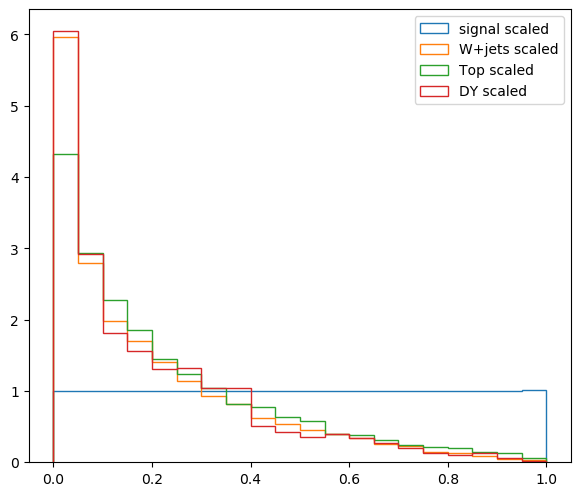

In [23]:
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)

nbins = 20 
plt.hist(signal["y_scaled"], weights=signal.weight_, bins=nbins,density=True, label="signal scaled", histtype="step",range=(0,1))
plt.hist(bkg[bkg.sample_name =="Wjets"]["y_scaled"], weights=bkg[bkg.sample_name =="Wjets"].weight_,
             bins=nbins,density=True, label="W+jets scaled", histtype="step",range=(0,1))
plt.hist(bkg[bkg.sample_name =="top"]["y_scaled"], weights=bkg[bkg.sample_name =="top"].weight_,
             bins=nbins,density=True, label="Top scaled", histtype="step",range=(0,1))
plt.hist(bkg[bkg.sample_name =="DY"]["y_scaled"], weights=bkg[bkg.sample_name =="DY"].weight_,
             bins=nbins,density=True, label="DY scaled", histtype="step",range=(0,1))
plt.legend()

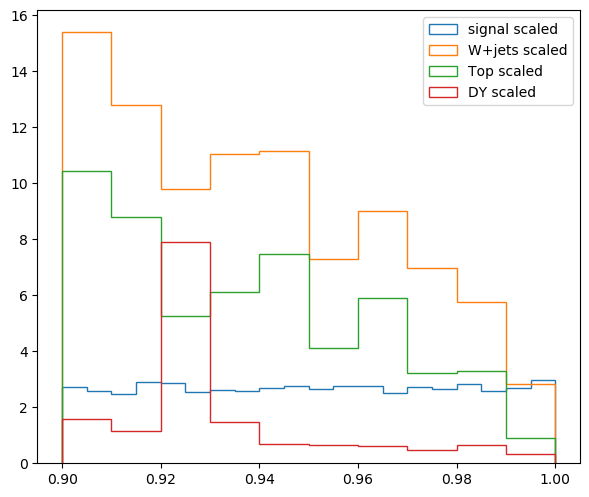

In [24]:
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)

plt.hist(signal["y_scaled"], weights=signal.weight_*130, bins=20, label="signal scaled", histtype="step",range=(0.9,1))
plt.hist(bkg[bkg.sample_name =="Wjets"]["y_scaled"], weights=bkg[bkg.sample_name =="Wjets"].weight_*130,
             bins=10, label="W+jets scaled", histtype="step",range=(0.9,1))
plt.hist(bkg[bkg.sample_name =="top"]["y_scaled"], weights=bkg[bkg.sample_name =="top"].weight_*130,
             bins=10,label="Top scaled", histtype="step",range=(0.9,1))
plt.hist(bkg[bkg.sample_name =="DY"]["y_scaled"], weights=bkg[bkg.sample_name =="DY"].weight_*130,
             bins=10, label="DY scaled", histtype="step",range=(0.9,1))
plt.legend()

# Significance optimization

In [8]:
import ROOT as R
file = R.TFile("cumulative_signal_boost_v5.root")
gr = file.Get("cumulative_signal")

Welcome to JupyROOT 6.18/00


In [9]:
sig18 = signal[signal.year == 2018]
sig17 = signal[signal.year == 2017]
bkg18 = bkg[bkg.year == 2018]
bkg17 = bkg[bkg.year == 2017]
sig18_ele = signal[(signal.year == 2018)&(signal.Lepton_flavour == 11)]
bkg18_ele = bkg[(bkg.year == 2018)&(bkg.Lepton_flavour == 11)]
sig18_mu = signal[(signal.year == 2018)&(signal.Lepton_flavour == 13)]
bkg18_mu = bkg[(bkg.year == 2018)&(bkg.Lepton_flavour == 13)]
sig17_ele = signal[(signal.year == 2017)&(signal.Lepton_flavour == 11)]
bkg17_ele = bkg[(bkg.year == 2017)&(bkg.Lepton_flavour == 11)]
sig17_mu = signal[(signal.year == 2017)&(signal.Lepton_flavour == 13)]
bkg17_mu = bkg[(bkg.year == 2017)&(bkg.Lepton_flavour == 13)]

In [11]:
sig18["y_scaled"] = sig18.y.map(gr.Eval)
sig17["y_scaled"] = sig17.y.map(gr.Eval)
bkg18["y_scaled"] = bkg18.y.map(gr.Eval)
bkg17["y_scaled"] = bkg17.y.map(gr.Eval)
sig18_ele["y_scaled"] = sig18_ele.y.map(gr.Eval)
bkg18_ele["y_scaled"] = bkg18_ele.y.map(gr.Eval)
sig18_mu["y_scaled"] = sig18_mu.y.map(gr.Eval)
bkg18_mu["y_scaled"] = bkg18_mu.y.map(gr.Eval)
sig17_ele["y_scaled"] = sig17_ele.y.map(gr.Eval)
bkg17_ele["y_scaled"] = bkg17_ele.y.map(gr.Eval)
sig17_mu["y_scaled"] = sig17_mu.y.map(gr.Eval)
bkg17_mu["y_scaled"] = bkg17_mu.y.map(gr.Eval)

/usr/local/bin/start_ipykernel.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/bin/start_ipykernel.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/bin/start_ipykernel.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/bin/start_ipykernel.

/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/numpy/lib/histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


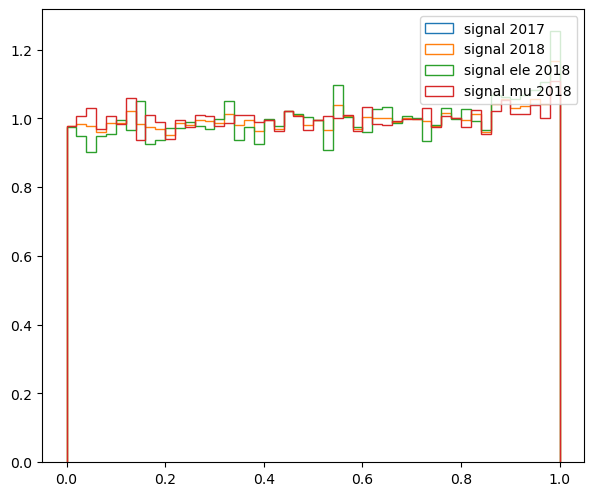

In [16]:
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)

plt.hist(sig17["y_scaled"], weights=sig17.weight_, bins=50,density=True, label="signal 2017", histtype="step",range=(0,1))
plt.hist(sig18["y_scaled"], weights=sig18.weight_, bins=50,density=True, label="signal 2018", histtype="step",range=(0,1))
plt.hist(sig18_ele["y_scaled"], weights=sig18_ele.weight_, bins=50,density=True, label="signal ele 2018", histtype="step",range=(0,1))
plt.hist(sig18_mu["y_scaled"], weights=sig18_mu.weight_, bins=50,density=True, label="signal mu 2018",   histtype="step",range=(0,1))

plt.legend()

[14.28883236 14.47470341 14.11423939 14.76966994 14.96801741 14.86315486
 14.6562272  15.01662576 15.11781574 16.02435497]
[17.98349895 17.35800057 15.7955317  15.77259979 14.35058031 13.76954761
 12.51061919 10.75044245  9.85274712  7.92478007]
[0.79455241 0.83389232 0.89355899 0.93641316 1.04302524 1.07942216
 1.17150294 1.39683793 1.5343757  2.02205674]


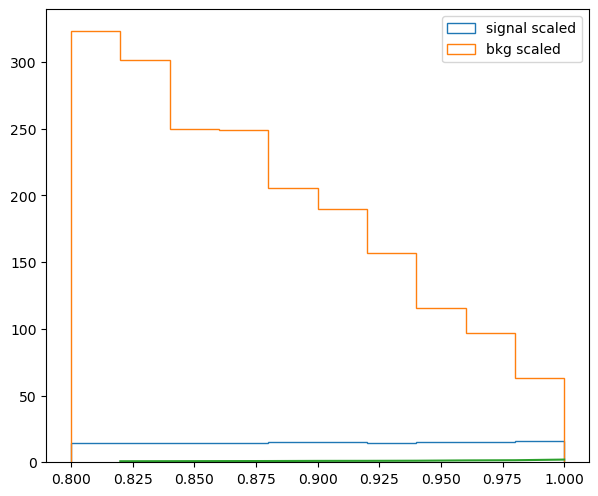

In [11]:
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)

lumi = 59.74
hs =  plt.hist(sig18["y_scaled"], weights=sig18.weight_*lumi, bins=10, label="signal scaled", histtype="step",range=(0.8,1))
hb = plt.hist(bkg18["y_scaled"], weights=bkg18.weight_*lumi, bins=10, label="bkg scaled", histtype="step",range=(0.8,1))
sig = hs[0] / np.sqrt(hb[0])
print(hs[0])
print(np.sqrt(hb[0]))
print(sig)
plt.plot(hs[1][1:], sig)
plt.legend()

## Binning by significance algo

In [13]:
from math import sqrt
def significance(bindown, binup,lumi, sig, bkg, syst=0, verbose=False):
    S = sig[(sig.y_scaled >= bindown) & (sig.y_scaled < binup)].weight_.sum() * lumi
    B = bkg[(bkg.y_scaled >= bindown) & (bkg.y_scaled < binup)].weight_.sum() * lumi
    sig_syst = S/sqrt(B + (syst*B)**2)
    if verbose: print(f"({bindown:.3f} - {binup:.3f}) S: {S:.1f}, B: {B:.1f}: sqrt(B): {sqrt(B):.1f}, sqrt(B+syst): {sqrt(B + (syst*B)):.1f} ---> sig {sig_syst:.1f}")
    return  sig_syst, S, B
    

In [23]:
x = np.linspace(0.4, 0.999, 100)

In [42]:
s0 = np.array([significance(xi,1, 59.74, sig18_ele, bkg18_ele, 0) for xi in x])
s05 = np.array([significance(xi,1, 59.74, sig18_ele, bkg18_ele, 0.05) for xi in x])
s1 = np.array([significance(xi,1, 59.74, sig18_ele, bkg18_ele, 0.1) for xi in x])
s2 = np.array([significance(xi,1, 59.74, sig18_ele, bkg18_ele, 0.2) for xi in x])

NameError: name 'x' is not defined

In [73]:
s2 = np.array([significance(xi,0.75, 59.74, sig18_ele, bkg18_ele, 0.0, True) for xi in x])

(0.400 - 0.750) S: 103.3, B: 7257.3: sqrt(B): 85.2, sqrt(B+syst): 85.2 ---> sig 1.2
(0.406 - 0.750) S: 101.5, B: 7058.5: sqrt(B): 84.0, sqrt(B+syst): 84.0 ---> sig 1.2
(0.412 - 0.750) S: 100.0, B: 6869.0: sqrt(B): 82.9, sqrt(B+syst): 82.9 ---> sig 1.2
(0.418 - 0.750) S: 98.2, B: 6651.5: sqrt(B): 81.6, sqrt(B+syst): 81.6 ---> sig 1.2
(0.424 - 0.750) S: 96.5, B: 6464.5: sqrt(B): 80.4, sqrt(B+syst): 80.4 ---> sig 1.2
(0.430 - 0.750) S: 94.9, B: 6279.0: sqrt(B): 79.2, sqrt(B+syst): 79.2 ---> sig 1.2
(0.436 - 0.750) S: 93.2, B: 6109.8: sqrt(B): 78.2, sqrt(B+syst): 78.2 ---> sig 1.2
(0.442 - 0.750) S: 91.3, B: 5924.9: sqrt(B): 77.0, sqrt(B+syst): 77.0 ---> sig 1.2
(0.448 - 0.750) S: 89.4, B: 5717.8: sqrt(B): 75.6, sqrt(B+syst): 75.6 ---> sig 1.2
(0.454 - 0.750) S: 87.7, B: 5526.5: sqrt(B): 74.3, sqrt(B+syst): 74.3 ---> sig 1.2
(0.461 - 0.750) S: 85.9, B: 5336.7: sqrt(B): 73.1, sqrt(B+syst): 73.1 ---> sig 1.2
(0.467 - 0.750) S: 84.2, B: 5174.9: sqrt(B): 71.9, sqrt(B+syst): 71.9 ---> sig 1.2
(

/usr/local/bin/start_ipykernel.py:5: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


(0.951 - 0.750) S: 0.0, B: 0.0: sqrt(B): 0.0, sqrt(B+syst): 0.0 ---> sig nan
(0.957 - 0.750) S: 0.0, B: 0.0: sqrt(B): 0.0, sqrt(B+syst): 0.0 ---> sig nan
(0.963 - 0.750) S: 0.0, B: 0.0: sqrt(B): 0.0, sqrt(B+syst): 0.0 ---> sig nan
(0.969 - 0.750) S: 0.0, B: 0.0: sqrt(B): 0.0, sqrt(B+syst): 0.0 ---> sig nan
(0.975 - 0.750) S: 0.0, B: 0.0: sqrt(B): 0.0, sqrt(B+syst): 0.0 ---> sig nan
(0.981 - 0.750) S: 0.0, B: 0.0: sqrt(B): 0.0, sqrt(B+syst): 0.0 ---> sig nan
(0.987 - 0.750) S: 0.0, B: 0.0: sqrt(B): 0.0, sqrt(B+syst): 0.0 ---> sig nan
(0.993 - 0.750) S: 0.0, B: 0.0: sqrt(B): 0.0, sqrt(B+syst): 0.0 ---> sig nan
(0.999 - 0.750) S: 0.0, B: 0.0: sqrt(B): 0.0, sqrt(B+syst): 0.0 ---> sig nan


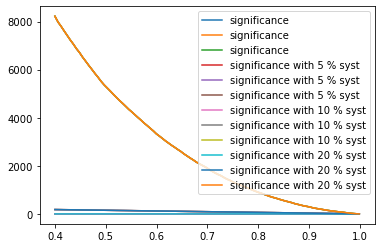

In [27]:
plt.plot(x, s0, label="significance")
plt.plot(x, s05, label="significance with 5 % syst")
plt.plot(x, s1, label="significance with 10 % syst")
plt.plot(x, s2, label="significance with 20 % syst")
plt.legend()

In [139]:
b = np.argmax(s05[:-1])
x[b]

0.9384949494949495

### Binning analysis electrons

In [15]:
signal = sig17_ele
bkg = bkg17_ele

bins = defaultdict(list)
significances = defaultdict(list)
Nsignal = defaultdict(list)

for syst in [0, 0.1, 0.2]:
    xmin = 0.3
    xmax = 1.
    while((xmax-xmin) > 0.01):
        xs = np.arange(xmax,xmin-0.005, -0.005)
        #print(xs)
        sigs = []
        NS = []
        for xi in xs[:-1]:
            signif, S, B= significance(xi, xmax, 59.74 , signal, bkg, syst) 
            #print(xi, xmax, S)
            if S < 5:
                #print("AAAA")
                sigs.append("-1")
                NS.append(S)
            else:
                sigs.append(signif)
                NS.append(S)
               
        amax = np.argmax(sigs)
        if sigs[amax] == "-1": break
        bins[syst].append(xs[amax])
        significances[syst].append(sigs[amax])
        Nsignal[syst].append(NS[amax])
        
        print(f"xmax:{xs[amax]}, significance: {sigs[amax]}")
        xmax = xs[amax]
    
    

/usr/local/bin/start_ipykernel.py:5: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


xmax:0.6249999999999997, significance: 1.475035445435357
xmax:0.3049999999999994, significance: 0.6471410844550701
xmax:0.8899999999999999, significance: 1.2065965935045855
xmax:0.7149999999999997, significance: 0.7447957806693565
xmax:0.5699999999999996, significance: 0.4470362360887118
xmax:0.4449999999999995, significance: 0.2731469066711637
xmax:0.3299999999999994, significance: 0.18572428168163338
xmax:0.8949999999999999, significance: 1.0079468330062982
xmax:0.7349999999999998, significance: 0.5099690283407237
xmax:0.6349999999999997, significance: 0.31206958641534155
xmax:0.5299999999999996, significance: 0.19720714164387554
xmax:0.4199999999999995, significance: 0.1486566612053559
xmax:0.3049999999999994, significance: 0.09356416892178596


In [17]:
print([ f"{x:.3f}" for x in bins[0.2]])
binning_ele_2017 = bins[0.2]
binning_ele_2017.reverse()
print(binning_ele_2017)

['0.895', '0.735', '0.635', '0.530', '0.420', '0.305']
[0.3049999999999994, 0.4199999999999995, 0.5299999999999996, 0.6349999999999997, 0.7349999999999998, 0.8949999999999999]


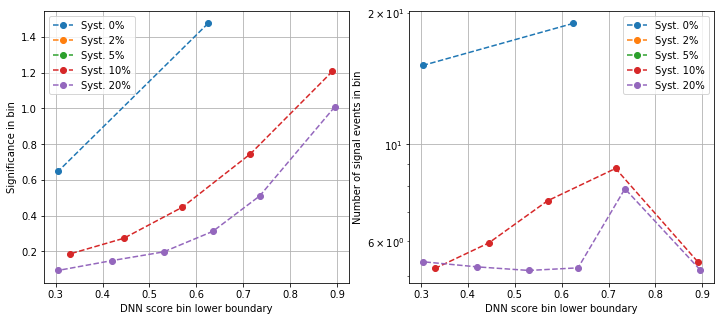

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))

for syst in [0, 0.02, 0.05, 0.1, 0.2]:
    axs[0].plot(bins[syst], significances[syst], "o--", label=f"Syst. {syst*100:.0f}%")
axs[0].legend()
axs[0].set_xlabel("DNN score bin lower boundary")
axs[0].set_ylabel("Significance in bin")
axs[0].grid("y")

for syst in [0, 0.02, 0.05, 0.1, 0.2]:
    axs[1].plot(bins[syst], Nsignal[syst], "o--", label=f"Syst. {syst*100:.0f}%")
axs[1].legend()
axs[1].set_xlabel("DNN score bin lower boundary")
axs[1].set_ylabel("Number of signal events in bin")
axs[1].set_yscale("log")
axs[1].grid("y")

fig.savefig("/eos/user/d/dvalsecc/www/VBSPlots/DNN_archive/plots/binning_ele_2017_boost.pdf")

## Binning analysis muon 2018

In [19]:
signal = sig17_mu
bkg = bkg17_mu

bins = defaultdict(list)
significances = defaultdict(list)
Nsignal = defaultdict(list)

for syst in [0.1,0.2,0.25]:
    xmin = 0.3
    xmax = 1.
    while((xmax-xmin) > 0.01):
        xs = np.arange(xmax,xmin-0.005, -0.005)
        #print(xs)
        sigs = []
        NS = []
        for xi in xs[1:]:
            signif, S, B= significance(xi, xmax, 59.74, signal, bkg, syst) 
            #print(xi, xmax, S)
            if S < 5:
                #print("AAAA")
                sigs.append("-1")
                NS.append(S)
            else:
                sigs.append(signif)
                NS.append(S)
        
        amax = np.argmax(sigs)
        if sigs[amax] == "-1": break
        bins[syst].append(xs[amax])
        significances[syst].append(sigs[amax])
        Nsignal[syst].append(NS[amax])
        print(f"xmax:{xs[amax]}, significance: {sigs[amax]}")
        xmax = xs[amax]
    
    

xmax:0.9199999999999999, significance: 1.4068956836971023
xmax:0.7649999999999998, significance: 0.8813233693973244
xmax:0.6349999999999997, significance: 0.5568380535932459
xmax:0.46999999999999953, significance: 0.34633262918107693
xmax:0.38999999999999946, significance: 0.24821501507799057
xmax:0.3049999999999994, significance: 0.1822185510544367
xmax:0.9199999999999999, significance: 1.1947114127931164
xmax:0.8199999999999998, significance: 0.597777930726088
xmax:0.7349999999999998, significance: 0.41322262559348333
xmax:0.6649999999999997, significance: 0.33529422468411224
xmax:0.5949999999999996, significance: 0.23262297701518433
xmax:0.49499999999999955, significance: 0.18636208358031872
xmax:0.4249999999999995, significance: 0.1543038857606031
xmax:0.35999999999999943, significance: 0.12115052774451018
xmax:0.9199999999999999, significance: 1.0864755035327733
xmax:0.8199999999999998, significance: 0.5089275603155966
xmax:0.7349999999999998, significance: 0.3489650313697148
xmax

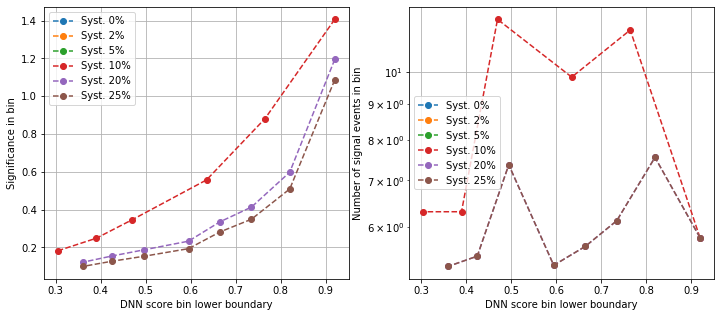

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))

for syst in [0, 0.02, 0.05, 0.1, 0.2, 0.25]:
    axs[0].plot(bins[syst], significances[syst], "o--", label=f"Syst. {syst*100:.0f}%")
axs[0].legend()
axs[0].set_xlabel("DNN score bin lower boundary")
axs[0].set_ylabel("Significance in bin")
axs[0].grid("y")

for syst in [0, 0.02, 0.05, 0.1, 0.2,0.25]:
    axs[1].plot(bins[syst], Nsignal[syst], "o--", label=f"Syst. {syst*100:.0f}%")
axs[1].legend()
axs[1].set_xlabel("DNN score bin lower boundary")
axs[1].set_ylabel("Number of signal events in bin")
axs[1].set_yscale("log")
axs[1].grid("y")

fig.savefig("/eos/user/d/dvalsecc/www/VBSPlots/DNN_archive/plots/binning_mu_2017_boost.pdf")

In [22]:
print([ f"{x:.3f}" for x in bins[0.2]])
binning_mu_2018 = bins[0.2]
binning_mu_2018.reverse()
print(binning_mu_2018)

['0.920', '0.820', '0.735', '0.665', '0.595', '0.495', '0.425', '0.360']
[0.35999999999999943, 0.4249999999999995, 0.49499999999999955, 0.5949999999999996, 0.6649999999999997, 0.7349999999999998, 0.8199999999999998, 0.9199999999999999]


In [19]:
print(binning_ele_2018.reverse())

NameError: name 'binning_ele_2018' is not defined